# Head

In [1]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/Othercomputers/retep's PC/MambaVAE")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Mounted at /content/gdrive


In [2]:
%pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == 

In [3]:
%pip install causal_conv1d

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.4 MB/s eta 0:00:00
  Created wheel for causal_conv1d: filename=causal_conv1d-1.5.0.post8-cp311-cp311

# vae

In [ ]:
import torch, InitMamba, importlib
from datasets import load_from_disk
importlib.reload(InitMamba)
import VAE
importlib.reload(VAE)
from VAE import MambaVAE
from transformers import MambaConfig, MambaForCausalLM, AutoTokenizer
from data.Dataset import get_dataset, tokenizer

vae = MambaVAE().cuda().eval()
vae.load_state_dict(torch.load('./results/vae/model.pth', weights_only=True), strict=False)

dataset = load_from_disk("./data/CoT3")
# train_dataset, eval_dataset = get_dataset()

In [ ]:
id = 1
question_ids = torch.tensor([dataset[id]['question_ids']], device='cuda')
question_mask = torch.tensor([dataset[id]['question_mask']], device='cuda')
full_ids = torch.tensor([dataset[id]['full_ids']], device='cuda')
full_mask = torch.tensor([dataset[id]['full_mask']], device='cuda')
full_loss_mask = torch.tensor([dataset[id]['full_loss_mask']], device='cuda')
tokenizer.batch_decode(full_ids, skip_special_tokens=True)[0]

In [ ]:
# input_ids, mask = question_ids, question_mask
# input_ids, mask = thoughts_ids, thoughts_mask
vae.eval()
state, log_var = vae.encode(full_ids, full_mask)

# idx = (state.abs() > 3)
# print(idx.sum() / state.numel())
# mix_state = state.clone()
# mix_state[idx] = torch.randn_like(state[idx])

res = vae.decode(state, full_ids, full_mask, full_loss_mask)
print(res.loss)
tokenizer.batch_decode(res.logits.argmax(-1), skip_special_tokens=True)

In [ ]:
r = 0.2
noise = torch.randn_like(state)
mix_state = (state*r**0.5+noise*(1-r)**0.5)

# idx = (state.abs() < 0.1)
# print(idx.sum() / state.numel())
# mix_state[idx] = torch.randn_like(state[idx]) * 0
vae.eval()
empty_ids = tokenizer('<|startoftext|>', return_tensors='pt').to('cuda')
tokens = vae.decoder.generate(input_ids = question_ids[:,:question_mask.sum()],
                inputs_ssm_states = vae.mlp2(mix_state),
                inputs_ssm_layer = 11,
                max_length = 256,
                # num_beams = 10
                )
tokenizer.batch_decode(tokens, skip_special_tokens=True)

In [ ]:
import matplotlib.pyplot as plt
vae.train()
data_np = states.flatten().detach().cpu().numpy()
plt.hist(data_np, bins=50)
plt.show()

In [ ]:
vae.sample(state, log_var)

# baseline


In [ ]:
import torch, transformers, os
from transformers import TrainingArguments, AutoTokenizer
from InitMamba import MambaForCausalLM
from datasets import load_dataset
import dataset.Dataset as Dataset

tokenizer = AutoTokenizer.from_pretrained("state-spaces/mamba-130m-hf")
model = MambaForCausalLM.from_pretrained('state-spaces/mamba-130m-hf').cuda()
dataset = load_dataset("arrow", data_files = './cache/CoT_full.arrow', split = 'train').select(range(100000))
print(dataset)
tot = len(dataset)
eval_size= int(tot * 0.05)
train_dataset = dataset.select(range(eval_size, tot))
eval_dataset = dataset.select(range(eval_size))
model.load_state_dict(torch.load("results/CoT_full/model.pth", weights_only=True))

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("state-spaces/mamba-130m-hf")
input_str = tokenizer.decode(eval_dataset[1]['input_ids'], skip_special_tokens=True)
input_ids = tokenizer(input_str.split(' Thinking: ')[0] + ' Thinking: ', return_tensors = 'pt')['input_ids'].cuda()
tokens = model.generate(
    input_ids,
    max_length = 512,
    # num_return_sequences = 5,
    # do_sample = False,
    # num_beams = 5
    )
print(input_str)
tokenizer.batch_decode(tokens)

# diffuser

In [65]:
import importlib, torch
from datasets import load_from_disk
from VAE import MambaVAE
from transformers import MambaConfig, MambaForCausalLM, AutoTokenizer

dataset = load_from_disk("./data/CoT3")

tokenizer = AutoTokenizer.from_pretrained("state-spaces/mamba-130m-hf")
tokenizer.add_tokens(["<|startoftext|>", "<|thoughts|>", "<|answer|>"])

vae = MambaVAE().cuda().eval()
vae.load_state_dict(torch.load('./results/vae0.2/model.pth', weights_only=True))

<All keys matched successfully>

In [66]:
import Diffuser, importlib, torch
importlib.reload(Diffuser)
from Diffuser import Diffuser
from safetensors.torch import load_file

diff = Diffuser().cuda().eval()
diff.load_state_dict(load_file('results/diff46'))

<All keys matched successfully>

In [73]:
id = 1
question_ids = torch.tensor([dataset[id]['question_ids']], device='cuda')
question_mask = torch.tensor([dataset[id]['question_mask']], device='cuda')
full_ids = torch.tensor([dataset[id]['full_ids']], device='cuda')
full_mask = torch.tensor([dataset[id]['full_mask']], device='cuda')
full_loss_mask = torch.tensor([dataset[id]['full_loss_mask']], device='cuda')

target = vae.encode(full_ids, full_mask)[0].clamp(-1, 1)
condition = vae.encode(question_ids, question_mask)[0].clamp(-1, 1)

tokenizer.batch_decode(full_ids, skip_special_tokens=True)

['<|startoftext|>Choose your reply from the options at the end. Does "The Tucson-Pima County Bicycle Advisory Committee (TPCBAC) serves in an advisory capacity to local governments on issues relating to bicycle recreation, transportation, and safety." contain the correct answer to "What organization advises the Tucson government on bike concerns?"\nOPTIONS:\n- yes\n- no<|thoughts|>The passage talks about the Tucson-Pima County Bicycle Advisory Committee serving in an advisory capacity to local governments on issues relating to bicycle recreation, transportation and safety. So, it does contain the correct answer for what organization advises the Tucson government on bike concerns. Hence, yes is our choice of reply<|answer|>yes']

In [72]:
res = diff(target = target, condition = condition)
print(res)

(tensor(0.0381, device='cuda:0', grad_fn=<MseLossBackward0>), tensor([345], device='cuda:0'), tensor([[[ 0.2466,  0.9780, -1.9853,  ...,  0.0105, -0.5977,  1.4626],
         [ 1.2544,  1.1357,  0.1588,  ..., -1.5082,  0.6754, -1.9053],
         [ 1.7816, -0.9212, -0.8135,  ...,  1.1966,  0.1445, -1.0007],
         ...,
         [-0.4906,  0.1381,  0.3975,  ...,  1.6413,  0.1816, -0.6768],
         [ 0.3688, -2.1655, -2.0415,  ..., -1.3300, -0.1609,  0.0128],
         [-0.9152, -0.5092, -1.0820,  ...,  1.4365,  0.4821,  0.4699]]],
       device='cuda:0', grad_fn=<AddBackward0>))


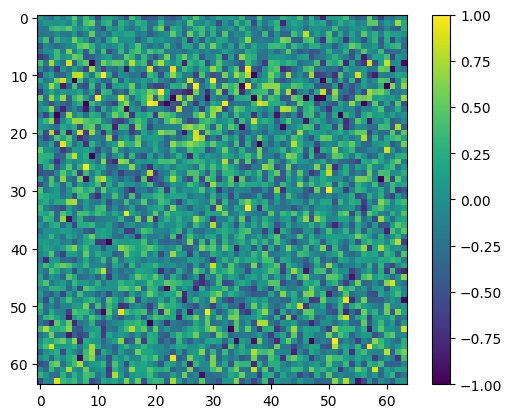

In [34]:
import matplotlib.pyplot as plt

plt.imshow(target.unsqueeze(-1).reshape(64, 64).detach().cpu())
plt.colorbar()
plt.show()

In [74]:
# states = diff.generate(condition, 1000)
print((states - target).pow(2).mean())
vae.decode(states, full_ids, full_mask, full_loss_mask)

tensor(0.4565, device='cuda:0', grad_fn=<MeanBackward0>)


MambaCausalLMOutput(loss=tensor(3.3588, device='cuda:0', grad_fn=<DivBackward0>), logits=tensor([[[ 17.9855,  -3.3020,  10.7381,  ...,   6.0614,  10.2098,  14.9412],
         [  0.7630, -11.4031,   3.0296,  ...,  -9.5272,  -8.0566,  -4.4180],
         [  5.7322,  -9.0858,   2.3787,  ...,  -7.8200,  -5.1280,  -4.5185],
         ...,
         [235.0085, -29.6433,  56.4529,  ..., -18.2519,  -9.9043, -10.6935],
         [235.0085, -29.6433,  56.4529,  ..., -18.2519,  -9.9043, -10.6935],
         [235.0085, -29.6433,  56.4529,  ..., -18.2519,  -9.9043, -10.6935]]],
       device='cuda:0', grad_fn=<UnsafeViewBackward0>), cache_params=<transformers.cache_utils.MambaCache object at 0x7b12c30343d0>, hidden_states=None, ssm_last_states=None)

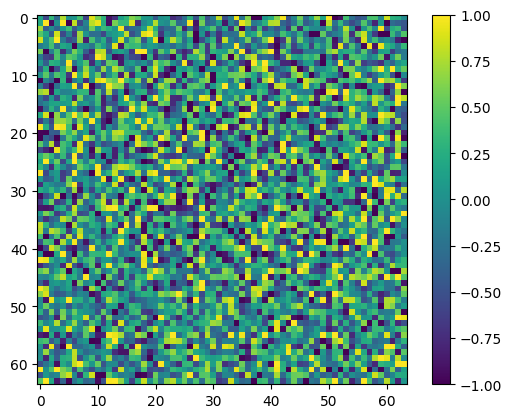

In [75]:
import torch
import matplotlib.pyplot as plt

plt.imshow(states.reshape(64, 64).detach().cpu())
plt.colorbar()
plt.show()

In [ ]:
r = 0
tokens = vae.decoder.generate(input_ids = question_ids[:,:question_mask.sum()],
                inputs_ssm_states = vae.mlp2(torch.randn_like(states)*r**0.5 + states*(1-r)**0.5),
                inputs_ssm_layer = 11,
                max_length = 256,
                # do_sample=True,
                # num_return_sequences=3
                )
tokenizer.batch_decode(tokens, skip_special_tokens=True)

# Run

In [ ]:
!python data/Dataset.py

In [ ]:
!python VAE_trainer.py

In [ ]:
!python Baseline_trainer.py

In [ ]:
!python Diffuser_trainer.py

In [ ]:
from google.colab import runtime
runtime.unassign()